# Previsão de preços de imóveis em Recife

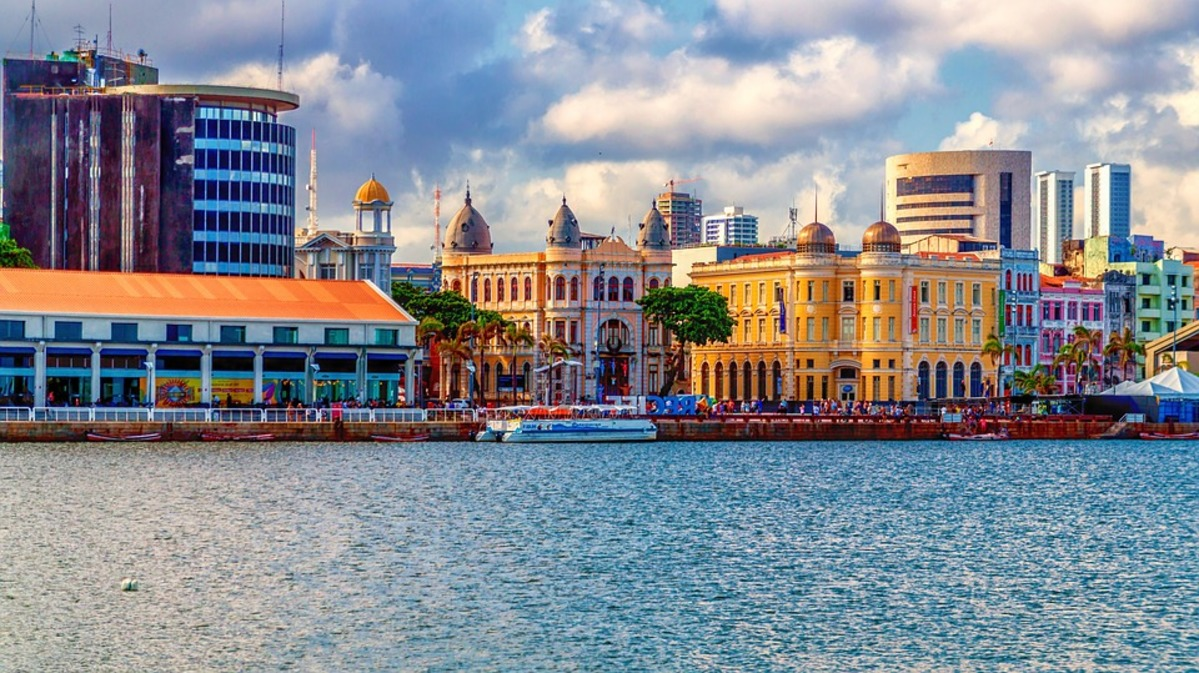

In [475]:
from IPython.display import Image
Image(filename='recife.jpeg')

**Recife** também conhecida como "Veneza Brasileira" é um município brasileiro, capital do estado de Pernambuco, localizado na Região Nordeste do país. Com área territorial de aproximadamente 218 km². É a cidade nordestina com o melhor Índice de Desenvolvimento Humano (IDH-M), o Recife é a quarta capital brasileira na hierarquia da gestão federal, após Brasília, Rio de Janeiro e São Paulo, e possui o quarto aglomerado urbano mais populoso do Brasil, com 4 milhões de habitantes em 2017, superado apenas pelas concentrações urbanas de São Paulo, Rio de Janeiro e Belo Horizonte.

In [3]:
#importanto bibliotecas e pacotes
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_score, RepeatedKFold, KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer, MaxAbsScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import make_pipeline
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras as tfk

import warnings
warnings.filterwarnings('ignore')

In [4]:
#importando a base de dados do arquivo CSV
train = pd.read_csv('conjunto_de_treinamento.csv')
#filtrando alguns valores extremos no preço
train = train.query('preco < 60000000')

test = pd.read_csv('conjunto_de_teste.csv')
#criando a coluna com os alvos
y = train['preco']


# Exploração dos dados

In [363]:
train.head().T

,0,1,2,3,4
Id,2000,2001,2002,2003,2004
tipo,Casa,Apartamento,Apartamento,Apartamento,Apartamento
bairro,Imbiribeira,Casa Amarela,Encruzilhada,Boa Viagem,Rosarinho
tipo_vendedor,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria
quartos,3,4,3,4,2
suites,3,4,1,3,1
vagas,5,2,0,2,1
area_util,223,157,53,149,54
area_extra,167,0,0,0,0
diferenciais,piscina e copa,piscina e churrasqueira,nenhum,piscina e churrasqueira,piscina e churrasqueira


In [362]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4680 entries, 0 to 4682
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              4680 non-null   int64  
 1   tipo            4680 non-null   object 
 2   bairro          4680 non-null   object 
 3   tipo_vendedor   4680 non-null   object 
 4   quartos         4680 non-null   float64
 5   suites          4680 non-null   float64
 6   vagas           4680 non-null   float64
 7   area_util       4680 non-null   float64
 8   area_extra      4680 non-null   float64
 9   diferenciais    4680 non-null   object 
 10  churrasqueira   4680 non-null   int64  
 11  estacionamento  4680 non-null   int64  
 12  piscina         4680 non-null   int64  
 13  playground      4680 non-null   int64  
 14  quadra          4680 non-null   int64  
 15  s_festas        4680 non-null   int64  
 16  s_jogos         4680 non-null   int64  
 17  s_ginastica     4680 non-null   i

Insights e Hipóteses:
- Nenhuma coluna apresenta valores faltantes

In [354]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,4680.0,4341.009829,1351.924510,2000.0,3170.75,4340.5,5511.25,6682.0
quartos,4680.0,3.044231,0.873226,1.0,3.00,3.0,4.00,9.0
suites,4680.0,1.434615,1.102562,0.0,1.00,1.0,2.00,6.0
vagas,4680.0,1.708547,1.211054,0.0,1.00,2.0,2.00,30.0
area_util,4680.0,124.193590,107.388397,21.0,68.00,96.0,149.00,2045.0
area_extra,4680.0,13.301709,266.889063,0.0,0.00,0.0,0.00,17450.0
estacionamento,4680.0,0.030769,0.172710,0.0,0.00,0.0,0.00,1.0
piscina,4680.0,0.555769,0.496933,0.0,0.00,1.0,1.00,1.0
playground,4680.0,0.157479,0.364290,0.0,0.00,0.0,0.00,1.0
quadra,4680.0,0.039103,0.193860,0.0,0.00,0.0,0.00,1.0


----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

In [619]:
#criei essa função para avaliar a normalidade de algumas colunas
def teste_normal(coluna):
    from scipy.stats import normaltest
    print('A hipótese H0 assume que a amostra É proveniente de uma distribuição normal.')
    print('A hipósete H1 assume que a a mostra NÃO é proveniente de uma distribuição normal.')
    print('')
    print('significância = 0.05')
    print('')
    print('Se P_VALOR < SINIFICÂNCIA, H0 é refutada, não é normal.')
    print('Se P_VALOR > SINIFICÂNCIA, H1 é refutada, é normal.')
    print('')
    print('')
    stat_test, p_valor = normaltest(coluna)
    if p_valor < 0.05:
        print('p_valor = {}, H0 refutada, NÃO É NORMAL'.format(p_valor))
    else:
        print('p_valor = {}, H1 refutada, É NORMAL'.format(p_valor))

## 1) tipo

In [111]:
train['tipo'].value_counts()

Apartamento    4499
Casa            176
Loft              3
Quitinete         2
Name: tipo, dtype: int64

In [112]:
train['tipo'].value_counts(normalize=True)

Apartamento    0.961325
Casa           0.037607
Loft           0.000641
Quitinete      0.000427
Name: tipo, dtype: float64

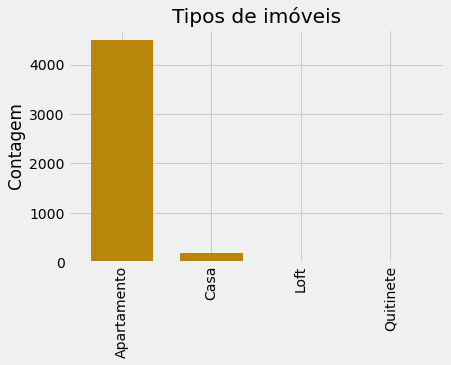

In [145]:
matplotlib.style.use('fivethirtyeight')
train['tipo'].value_counts().plot(kind='bar', width=0.7, color='#b8860b')
plt.title('Tipos de imóveis')
plt.ylabel('Contagem')
plt.show()

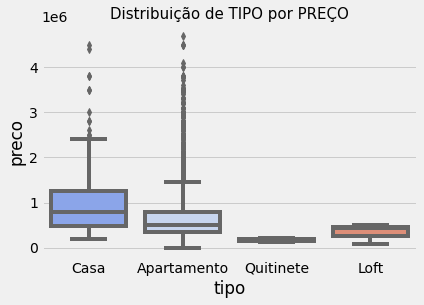

In [155]:
dado_filtrado = train.query('preco < 5000000')
sns.boxplot(data=dado_filtrado, x='tipo', y= 'preco', palette='coolwarm')
plt.title('Distribuição de TIPO por PREÇO', fontdict={'fontsize': 15})
plt.show()

- As casas tendem a ter um calor maior mesmo tendo uma quantidade bem menor de linhas

In [ ]:
fig = plt.figure(figsize=(5,5))
sns.lmplot(x='quartos', y='preco', data=train, markers='.', line_kws={'color':'red'})
plt.title('Numero de QUARTOS x PREÇO')
plt.show()

## 2) bairro

In [114]:
train['bairro'].value_counts().head(10)

Boa Viagem      1599
Madalena         327
Torre            239
Casa Amarela     225
Espinheiro       208
Rosarinho        202
Casa Forte       198
Encruzilhada     163
Parnamirim       123
Gracas           115
Name: bairro, dtype: int64

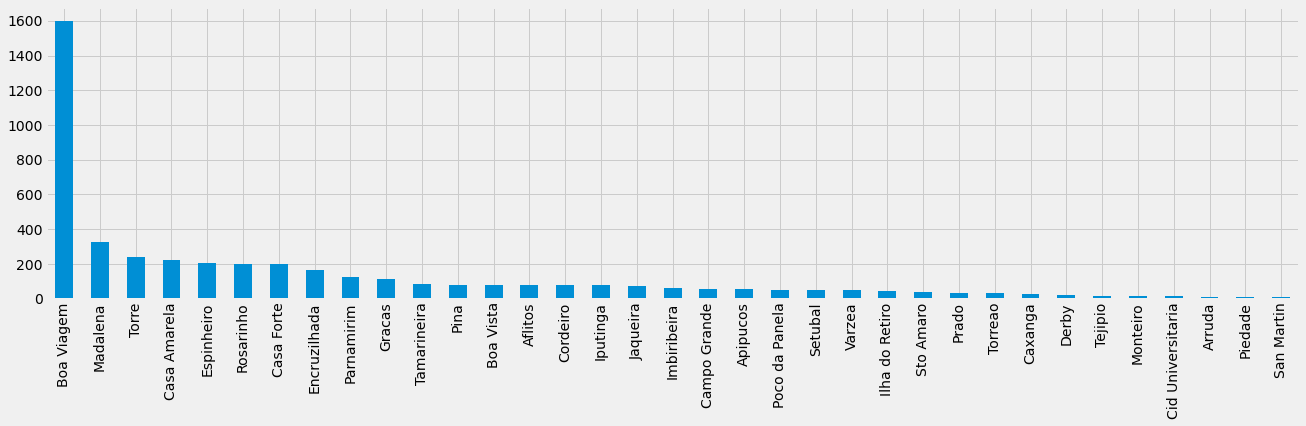

In [940]:
train['bairro'].value_counts().head(35).plot(kind='bar', figsize=(20,5))
plt.show()

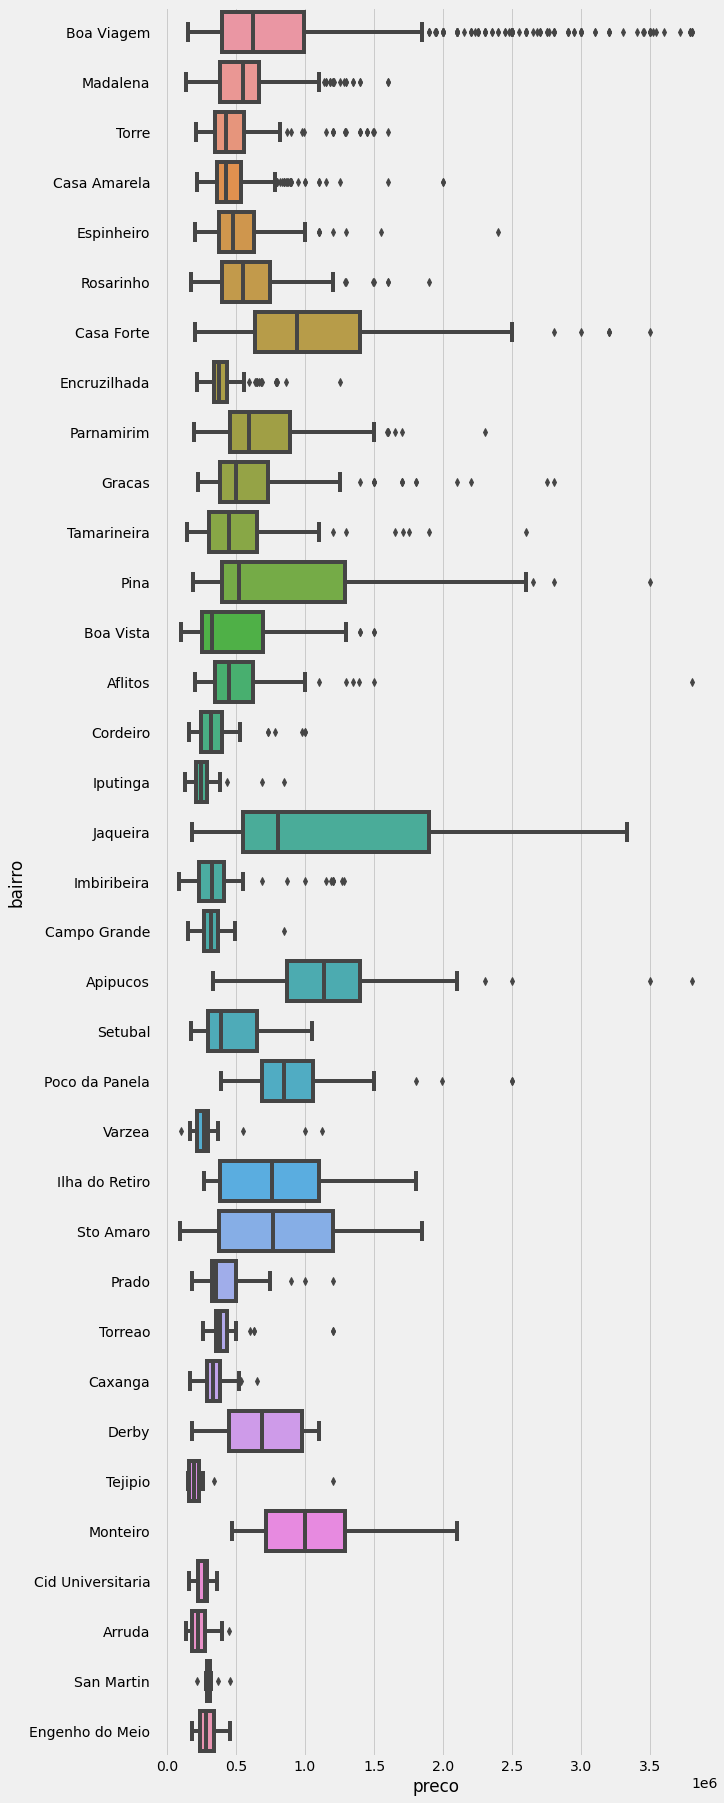

In [975]:
fig=plt.figure(figsize=(9,30))
cod_coluna = train['bairro'].value_counts()[:35]
aaa=cod_coluna.index
#primeiros_bairros = train.query('bairro in @cod_coluna')
sns.boxplot(x='preco', y='bairro', data=train, order =aaa )
plt.show()

## 3) quartos

In [926]:
train['quartos'].value_counts()

3    2277
4    1224
2     891
1     188
5      65
6      21
7       7
8       3
9       2
Name: quartos, dtype: int64

In [44]:
train['quartos'].value_counts(normalize=True)

3    0.486435
4    0.261910
2    0.190344
1    0.040376
5    0.013886
6    0.004486
7    0.001495
8    0.000641
9    0.000427
Name: quartos, dtype: float64

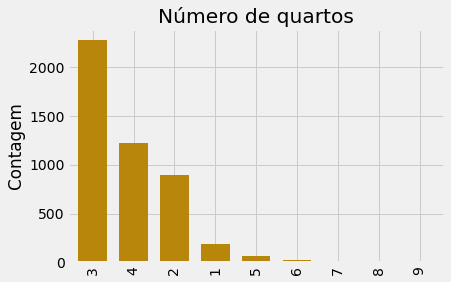

In [128]:
matplotlib.style.use('fivethirtyeight')
train['quartos'].value_counts().plot(kind='bar', width=0.7, color='#b8860b')
plt.title('Número de quartos')
plt.ylabel('Contagem')
plt.show()

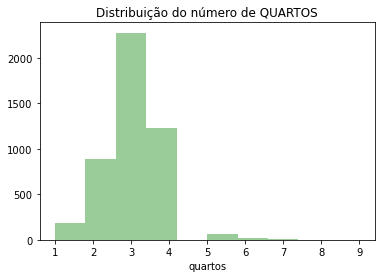

In [102]:
ax = sns.distplot(a=train['quartos'], color='green', bins=10, kde=False)
plt.title('Distribuição do número de QUARTOS')
plt.show()

In [79]:
#testando se a distribuição de QUARTOS é normal
teste_normal(train['quartos'])

A hipótese H0 assume que a amostra É proveniente de uma distribuição normal.
A hipósete H1 assume que a a mostra NÃO é proveniente de uma distribuição normal.

significância = 0.05

Se P_VALOR < SINIFICÂNCIA, H0 é refutada, não é normal.
Se P_VALOR > SINIFICÂNCIA, H1 é refutada, é normal.


p_valor = 2.800893917625703e-60, H0 refutada, NÃO É NORMAL


<Figure size 360x360 with 0 Axes>

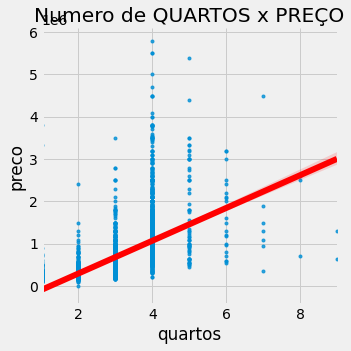

In [897]:
fig = plt.figure(figsize=(5,5))
sns.lmplot(x='quartos', y='preco', data=train, markers='.', line_kws={'color':'red'})
plt.title('Numero de QUARTOS x PREÇO')
plt.show()

Insights e Hipóteses:
- Com o gráfico acima fica bem fácil enxergar uma tendência do número de quartos com aumento do preço

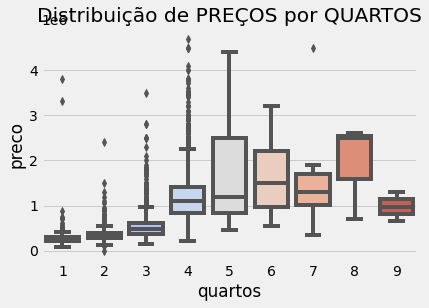

In [131]:
dado_filtrado = train.query('preco < 5000000')
sns.boxplot(data=dado_filtrado, x='quartos', y= 'preco', palette='coolwarm')
plt.title('Distribuição de PREÇOS por QUARTOS')
plt.show()

- No boxplot acima também podemos observar uma tendência de aumento dos preços pela quantidade de quartos

## 4) suites

In [94]:
train['suites'].value_counts()

1    2724
2     667
0     562
4     427
3     278
5      18
6       4
Name: suites, dtype: int64

In [95]:
train['suites'].value_counts(normalize=True)

1    0.582051
2    0.142521
0    0.120085
4    0.091239
3    0.059402
5    0.003846
6    0.000855
Name: suites, dtype: float64

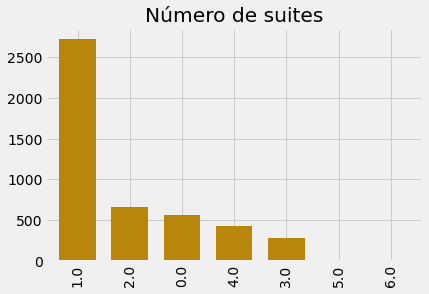

In [478]:
matplotlib.style.use('fivethirtyeight')
train['suites'].value_counts().plot(kind='bar', width=0.7, color='#b8860b')
plt.title('Número de suites')
plt.show()

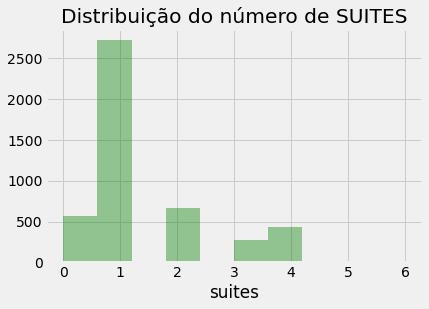

In [133]:
matplotlib.style.use('fivethirtyeight')
ax = sns.distplot(a=train['suites'], color='green', bins=10, kde=False)
plt.title('Distribuição do número de SUITES')
plt.show()

In [103]:
#testando se a distribuição de SUITES é normal
teste_normal(train['suites'])

A hipótese H0 assume que a amostra É proveniente de uma distribuição normal.
A hipósete H1 assume que a a mostra NÃO é proveniente de uma distribuição normal.

significância = 0.05

Se P_VALOR < SINIFICÂNCIA, H0 é refutada, não é normal.
Se P_VALOR > SINIFICÂNCIA, H1 é refutada, é normal.


p_valor = 2.4608079207426815e-182, H0 refutada, NÃO É NORMAL


<Figure size 360x360 with 0 Axes>

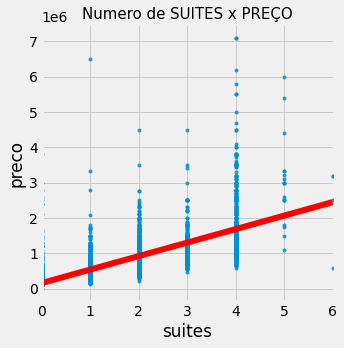

In [140]:
fig = plt.figure(figsize=(5,5))
sns.lmplot(x='suites', y='preco', data=train, markers='.', line_kws={'color':'red'})
plt.title('Numero de SUITES x PREÇO', fontdict={'fontsize':15})
plt.show()

Insights e Hipóteses:
- Aqui também vemos uma tendência de aumento de preço com o número de suites

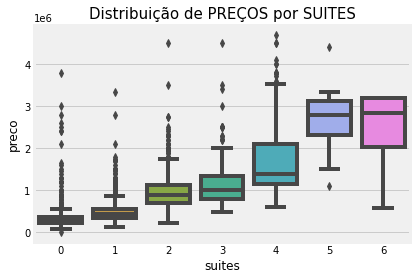

In [336]:
#boxplot dos preços segmentado pelo número de suites

#filtrei os dados aqui para que valores extremos não atrapalhem nossa visalização
dado_filtrado = train.query('preco < 5000000')
sns.boxplot(data=dado_filtrado, x='suites', y= 'preco')
plt.title('Distribuição de PREÇOS por SUITES', fontdict={'fontsize':15})
plt.show()

- Como nos QUARTOS também observamos uma tendência de aumento no preço quando cresce o número de SUITES

## 6) vagas

In [500]:
train['vagas'].value_counts()

1.0     1976
2.0     1650
3.0      578
0.0      285
4.0      115
5.0       41
6.0       17
8.0        5
10.0       4
7.0        2
30.0       1
20.0       1
18.0       1
12.0       1
13.0       1
15.0       1
17.0       1
Name: vagas, dtype: int64

70.0     89
60.0     85
55.0     83
90.0     77
75.0     74
         ..
354.0     1
343.0     1
249.0     1
453.0     1
227.0     1
Name: area_util, Length: 356, dtype: int64

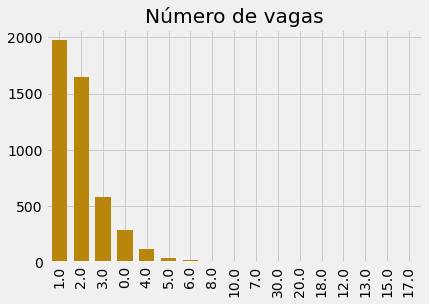

In [479]:
matplotlib.style.use('fivethirtyeight')
train['vagas'].value_counts().plot(kind='bar', width=0.7, color='#b8860b')
plt.title('Número de vagas')
plt.xlabel()
plt.show()

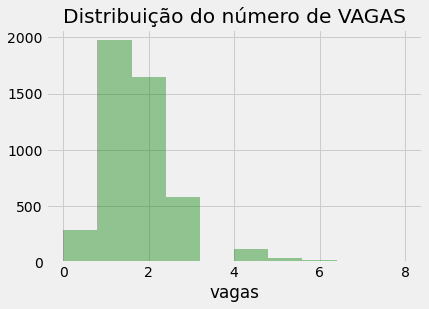

In [490]:
ax = sns.distplot(a=train.query('vagas<10')['vagas'], color='green', bins=10, kde=False)
plt.title('Distribuição do número de VAGAS')
plt.show()

<Figure size 360x360 with 0 Axes>

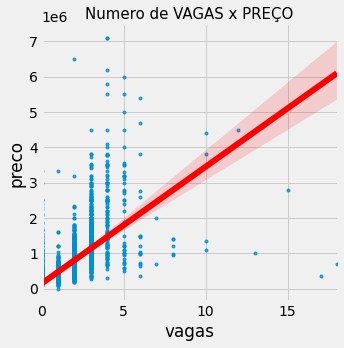

In [492]:
fig = plt.figure(figsize=(5,5))
sns.lmplot(x='vagas', y='preco', data=train.query('vagas<20'), markers='.', line_kws={'color':'red'})
plt.title('Numero de VAGAS x PREÇO', fontdict={'fontsize':15})
plt.show()

Correlação bem aparende entre o número de vagas e o preço do imóvel

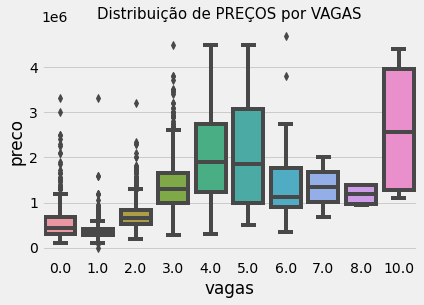

In [497]:
#boxplot dos preços segmentado pelo número de suites

#filtrei os dados aqui para que valores extremos não atrapalhem nossa visalização
dado_filtrado = train.query('preco < 5000000 and vagas<12')
sns.boxplot(data=dado_filtrado, x='vagas', y= 'preco')
plt.title('Distribuição de PREÇOS por VAGAS', fontdict={'fontsize':15})
plt.show()

- Há um um aumento de preços em relação ao número de vagas a partir 1 até 5 vagas

## 7) area_util

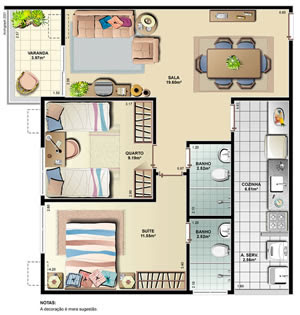

In [536]:
from IPython.display import Image
Image(filename='area_util.png')

In [845]:
train['area_util'].value_counts().head(10)

70     89
60     85
55     83
90     77
75     74
80     73
63     73
62     70
100    66
120    65
Name: area_util, dtype: int64

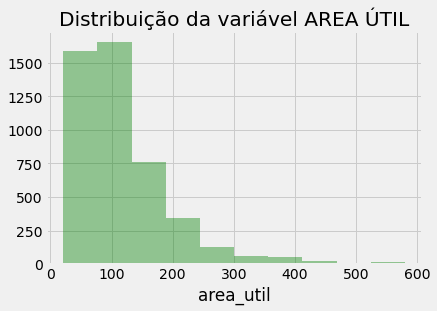

In [846]:
matplotlib.style.use('fivethirtyeight')
ax = sns.distplot(a=train.query('area_util<600')['area_util'], color='green', bins=10, kde=False)
plt.title('Distribuição da variável AREA ÚTIL')
plt.show()

<Figure size 360x360 with 0 Axes>

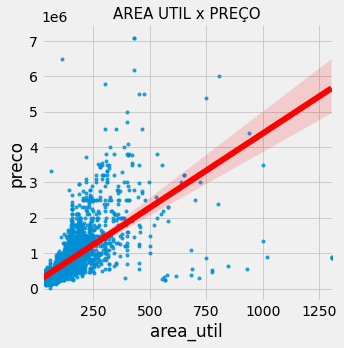

In [848]:
fig = plt.figure(figsize=(5,5))
sns.lmplot(x='area_util', y='preco', data=train.query('area_util<1500'), markers='.', line_kws={'color':'red'})
plt.title('AREA UTIL x PREÇO', fontdict={'fontsize':15})
plt.show()

## 8) area_extra

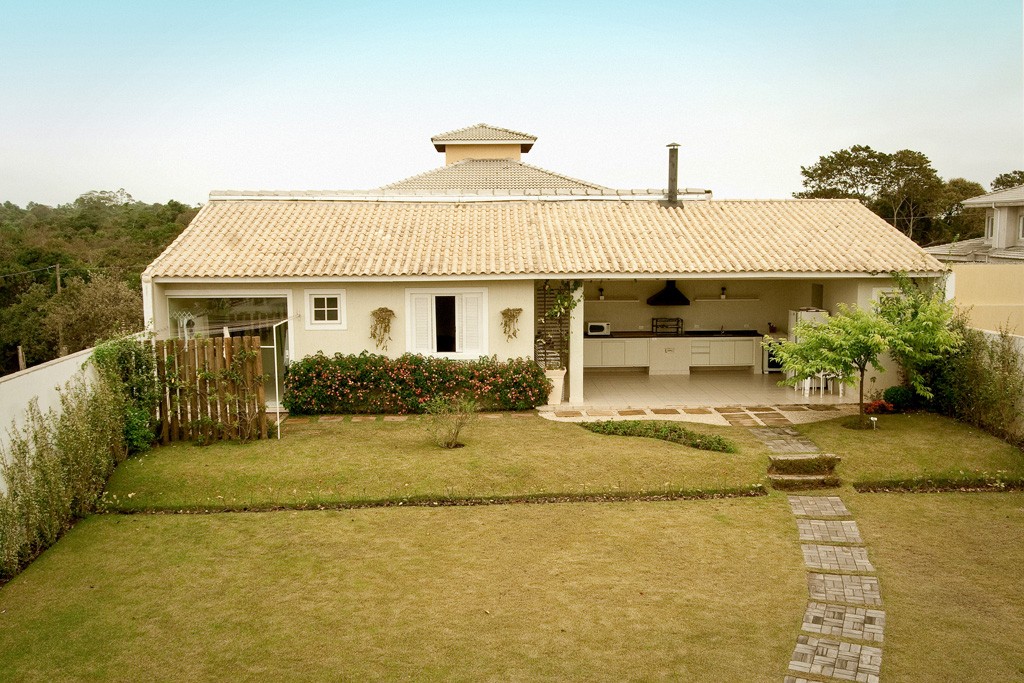

In [575]:
from IPython.display import Image
Image(filename='area_extra.jpg')

In [552]:
train['area_extra'].value_counts().head(10)

0.0     4131
30.0      37
20.0      30
10.0      27
40.0      15
12.0      15
25.0      10
15.0      10
11.0      10
60.0       9
Name: area_extra, dtype: int64

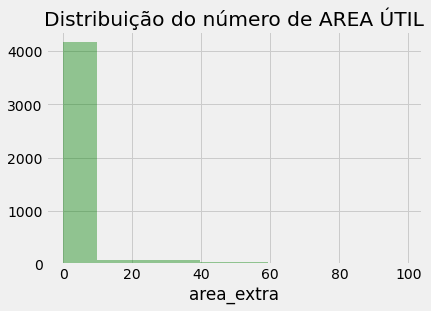

In [551]:
matplotlib.style.use('fivethirtyeight')
ax = sns.distplot(a=train.query('area_extra<100')['area_extra'], color='green', bins=10, kde=False)
plt.title('Distribuição do número de AREA ÚTIL')
plt.show()

- muitos valores com zero

<Figure size 360x360 with 0 Axes>

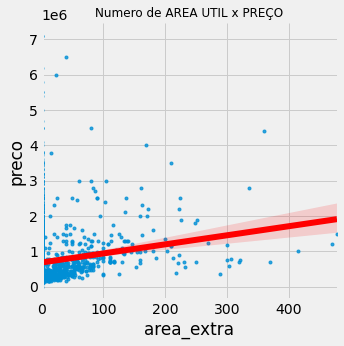

In [554]:
fig = plt.figure(figsize=(5,5))
sns.lmplot(x='area_extra', y='preco', data=train.query('area_extra<500'), markers='.', line_kws={'color':'red'})
plt.title('Numero de AREA UTIL x PREÇO', fontdict={'fontsize':12})
plt.show()

- Ainda é possível observar uma pequena correlação entre AREA_EXTRA e PRECO

In [557]:
train.shape

(4680, 112)

## 9) diferenciais

## 10) churrasqueira

In [559]:
train['churrasqueira'].value_counts()

0    3197
1    1483
Name: churrasqueira, dtype: int64

In [560]:
train['churrasqueira'].value_counts(normalize=True)

0    0.68312
1    0.31688
Name: churrasqueira, dtype: float64

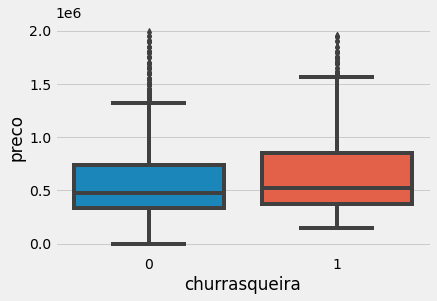

In [571]:
sns.boxplot(x='churrasqueira', y='preco', data=train.query('preco<2000000'))
plt.show()

- As casas com churrasqueiras parecerem com um preço um pouco maior 

## 11) estacionamento

In [576]:
train['estacionamento'].value_counts()

0    4536
1     144
Name: estacionamento, dtype: int64

In [577]:
train['estacionamento'].value_counts(normalize=True)

0    0.969231
1    0.030769
Name: estacionamento, dtype: float64

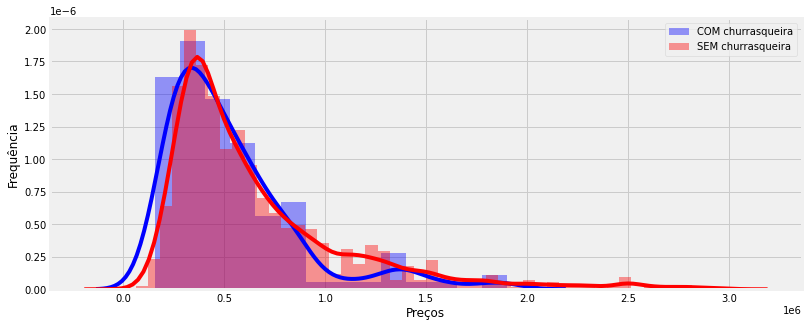

In [615]:
#distribuição dos preços pra quem tem churrasqueira
fig = plt.figure(figsize=(12,5))
sns.distplot(a=train.query('preco<3000000 and estacionamento==1')['preco'],color='blue',label= 'COM churrasqueira')
#distribuição dos preços pra quem tem NÃO churrasqueira
sns.distplot(a=train.query('preco<3000000 and estacionamento==0')['preco'],color='red', label= 'SEM churrasqueira')
plt.legend()
plt.ylabel('Frequência')
plt.xlabel('Preços')

plt.show()

- No geral as distribuições parecem bem próximas exceto no intervalo de 1 a 1.5 milões, onde vemos menos imóveis COM churrasqueira nessa faixa de preço.

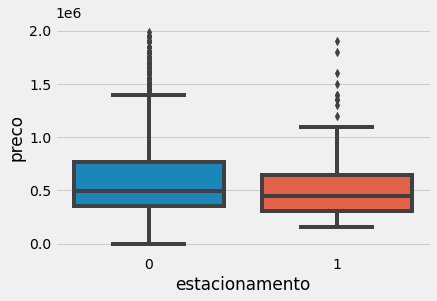

In [579]:
sns.boxplot(x='estacionamento', y='preco', data=train.query('preco<2000000'))
plt.show()

## 12) piscina

In [605]:
train['piscina'].value_counts()

1    2601
0    2079
Name: piscina, dtype: int64

In [606]:
train['piscina'].value_counts(normalize=True)

1    0.555769
0    0.444231
Name: piscina, dtype: float64

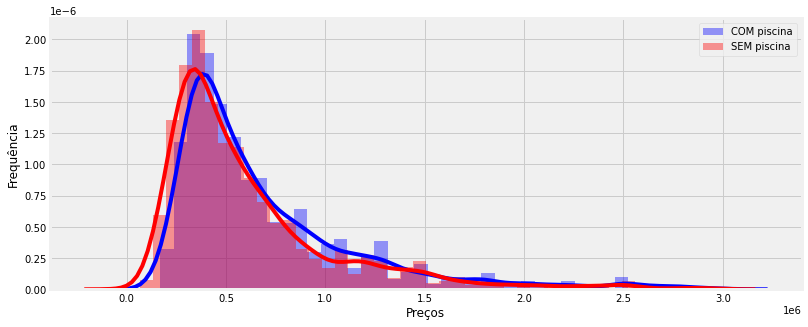

In [614]:
#distribuição dos preços pra quem tem piscina
fig = plt.figure(figsize=(12,5))
sns.distplot(a=train.query('preco<3000000 and piscina==1')['preco'],color='blue',label= 'COM piscina')
#distribuição dos preços pra quem tem NÃO piscina
sns.distplot(a=train.query('preco<3000000 and piscina==0')['preco'],color='red', label= 'SEM piscina')
plt.legend()
plt.ylabel('Frequência')
plt.xlabel('Preços')

plt.show()

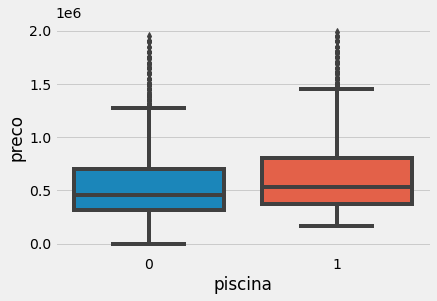

In [608]:
sns.boxplot(x='piscina', y='preco', data=train.query('preco<2000000'))
plt.show()

## 13) playground

In [616]:
train['playground'].value_counts()

0    3943
1     737
Name: playground, dtype: int64

In [617]:
train['playground'].value_counts(normalize=True)

0    0.842521
1    0.157479
Name: playground, dtype: float64

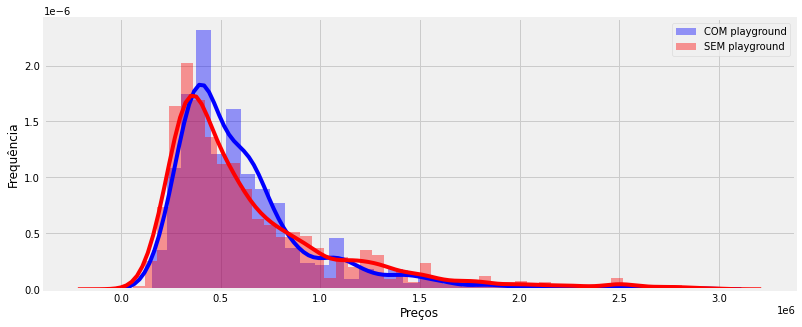

In [622]:
#distribuição dos preços pra quem tem piscina
fig = plt.figure(figsize=(12,5))
sns.distplot(a=train.query('preco<3000000 and playground==1')['preco'],color='blue',label= 'COM playground')
#distribuição dos preços pra quem tem NÃO piscina
sns.distplot(a=train.query('preco<3000000 and playground==0')['preco'],color='red', label= 'SEM playground')
plt.legend()
plt.ylabel('Frequência')
plt.xlabel('Preços')
plt.show()

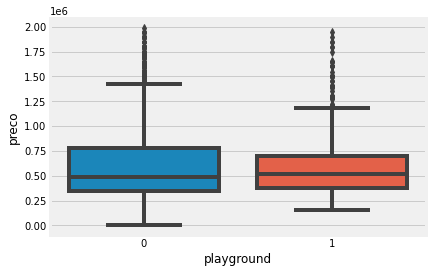

In [623]:
sns.boxplot(x='playground', y='preco', data=train.query('preco<2000000'))
plt.show()

## 14) quadra

In [624]:
train['quadra'].value_counts()

0    4497
1     183
Name: quadra, dtype: int64

In [625]:
train['quadra'].value_counts(normalize=True)

0    0.960897
1    0.039103
Name: quadra, dtype: float64

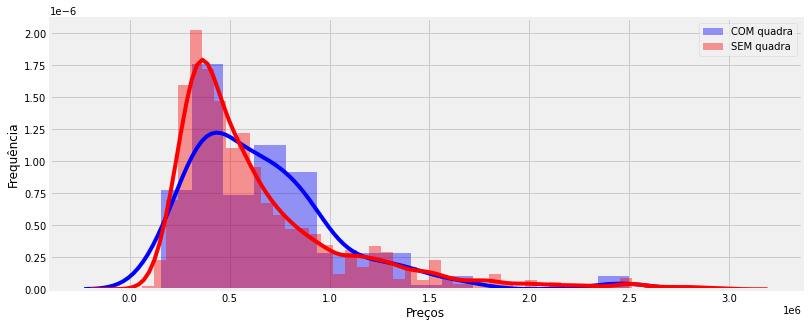

In [626]:
#distribuição dos preços pra quem tem piscina
fig = plt.figure(figsize=(12,5))
sns.distplot(a=train.query('preco<3000000 and quadra==1')['preco'],color='blue',label= 'COM quadra')
#distribuição dos preços pra quem tem NÃO piscina
sns.distplot(a=train.query('preco<3000000 and quadra==0')['preco'],color='red', label= 'SEM quadra')
plt.legend()
plt.ylabel('Frequência')
plt.xlabel('Preços')
plt.show()

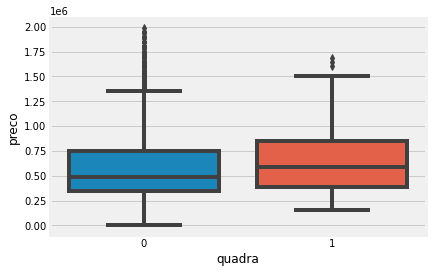

In [627]:
sns.boxplot(x='quadra', y='preco', data=train.query('preco<2000000'))
plt.show()

## 15) s_festas

In [628]:
train['s_festas'].value_counts()

0    4034
1     646
Name: s_festas, dtype: int64

In [629]:
train['s_festas'].value_counts(normalize=True)

0    0.861966
1    0.138034
Name: s_festas, dtype: float64

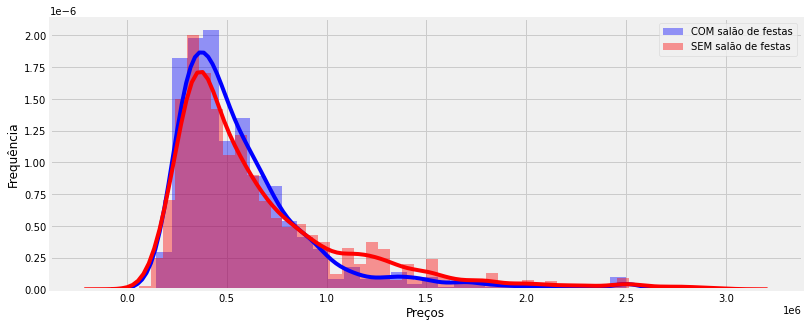

In [630]:
#distribuição dos preços pra quem tem piscina
fig = plt.figure(figsize=(12,5))
sns.distplot(a=train.query('preco<3000000 and s_festas==1')['preco'],color='blue',label= 'COM salão de festas')
#distribuição dos preços pra quem tem NÃO piscina
sns.distplot(a=train.query('preco<3000000 and s_festas==0')['preco'],color='red', label= 'SEM salão de festas')
plt.legend()
plt.ylabel('Frequência')
plt.xlabel('Preços')
plt.show()

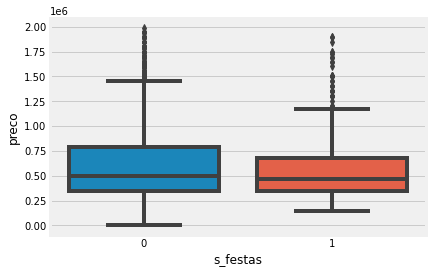

In [631]:
sns.boxplot(x='s_festas', y='preco', data=train.query('preco<2000000'))
plt.show()

## 16) s_jogos

In [632]:
train['s_jogos'].value_counts()

0    4648
1      32
Name: s_jogos, dtype: int64

In [633]:
train['s_jogos'].value_counts(normalize=True)

0    0.993162
1    0.006838
Name: s_jogos, dtype: float64

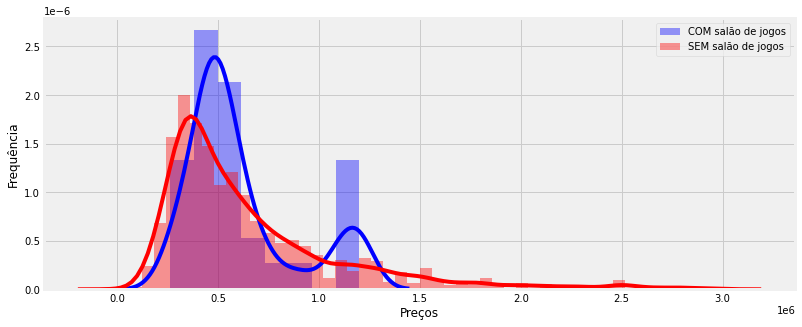

In [634]:
#distribuição dos preços pra quem tem piscina
fig = plt.figure(figsize=(12,5))
sns.distplot(a=train.query('preco<3000000 and s_jogos==1')['preco'],color='blue',label= 'COM salão de jogos')
#distribuição dos preços pra quem tem NÃO piscina
sns.distplot(a=train.query('preco<3000000 and s_jogos==0')['preco'],color='red', label= 'SEM salão de jogos')
plt.legend()
plt.ylabel('Frequência')
plt.xlabel('Preços')
plt.show()

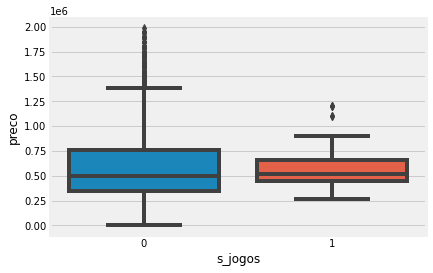

In [635]:
sns.boxplot(x='s_jogos', y='preco', data=train.query('preco<2000000'))
plt.show()

## 17) s_ginastica

In [636]:
train['s_ginastica'].value_counts()

0    4616
1      64
Name: s_ginastica, dtype: int64

In [637]:
train['s_ginastica'].value_counts(normalize=True)

0    0.986325
1    0.013675
Name: s_ginastica, dtype: float64

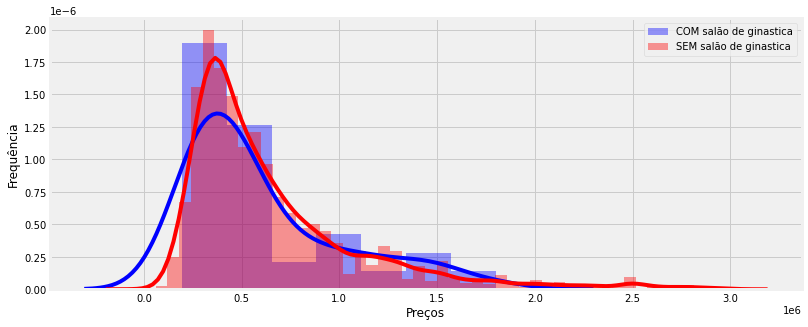

In [638]:
#distribuição dos preços pra quem tem piscina
fig = plt.figure(figsize=(12,5))
sns.distplot(a=train.query('preco<3000000 and s_ginastica==1')['preco'],color='blue',label= 'COM salão de ginastica')
#distribuição dos preços pra quem tem NÃO piscina
sns.distplot(a=train.query('preco<3000000 and s_ginastica==0')['preco'],color='red', label= 'SEM salão de ginastica')
plt.legend()
plt.ylabel('Frequência')
plt.xlabel('Preços')
plt.show()

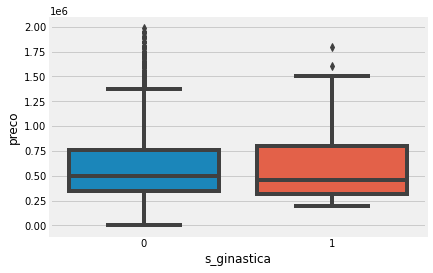

In [642]:
sns.boxplot(x='s_ginastica', y='preco', data=train.query('preco<2000000'))
plt.show()

## 18) sauna

In [639]:
train['sauna'].value_counts()

0    4229
1     451
Name: sauna, dtype: int64

In [640]:
train['sauna'].value_counts(normalize=True)

0    0.903632
1    0.096368
Name: sauna, dtype: float64

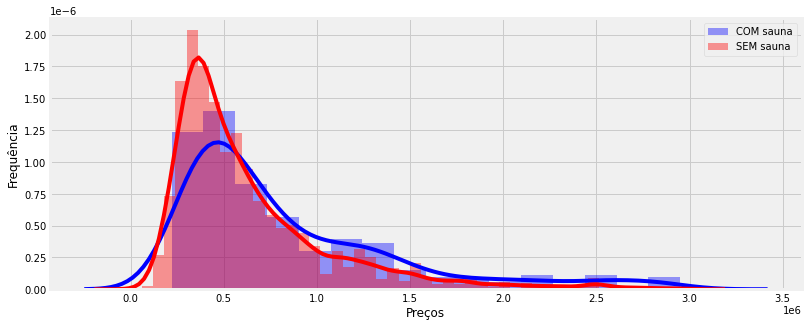

In [647]:
#distribuição dos preços pra quem tem piscina
fig = plt.figure(figsize=(12,5))
sns.distplot(a=train.query('preco<3000000 and sauna==1')['preco'],color='blue',label= 'COM sauna')
#distribuição dos preços pra quem tem NÃO piscina
sns.distplot(a=train.query('preco<3000000 and sauna==0')['preco'],color='red', label= 'SEM sauna')
plt.legend()
plt.ylabel('Frequência')
plt.xlabel('Preços')
plt.show()

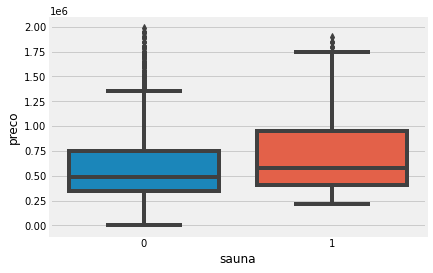

In [643]:
sns.boxplot(x='sauna', y='preco', data=train.query('preco<2000000'))
plt.show()

## 19) vista_mar

In [644]:
train['vista_mar'].value_counts()

0    4552
1     128
Name: vista_mar, dtype: int64

In [645]:
train['vista_mar'].value_counts(normalize=True)

0    0.97265
1    0.02735
Name: vista_mar, dtype: float64

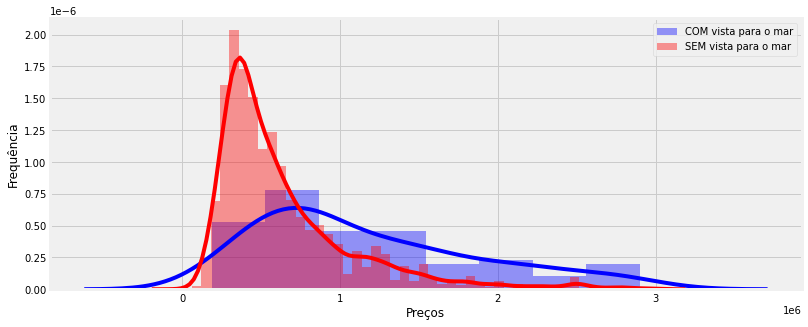

In [646]:
#distribuição dos preços pra quem tem piscina
fig = plt.figure(figsize=(12,5))
sns.distplot(a=train.query('preco<3000000 and vista_mar==1')['preco'],color='blue',label= 'COM vista para o mar')
#distribuição dos preços pra quem tem NÃO piscina
sns.distplot(a=train.query('preco<3000000 and vista_mar==0')['preco'],color='red', label= 'SEM vista para o mar')
plt.legend()
plt.ylabel('Frequência')
plt.xlabel('Preços')
plt.show()

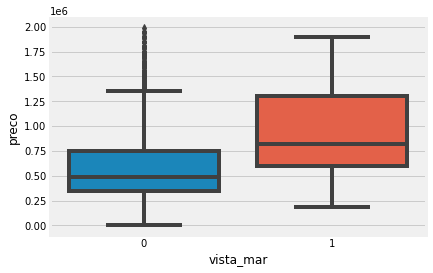

In [649]:
sns.boxplot(x='vista_mar', y='preco', data=train.query('preco<2000000'))
plt.show()

# Testando modelos com scalers diferentes

In [ ]:
#transformando os atributos numéricos contínuos em float
train[['area_util', 'area_extra', 'quartos', 'suites', 'vagas']] = train[['area_util', 'area_extra', 'quartos', 'suites', 'vagas']].astype('float64')
#criando um dataframe com os valores numéricos
X_num = train.select_dtypes('float').drop(['preco'],axis=1)
y = train['preco']

In [ ]:
mdl = xgb.XGBRegressor()
scores_sem_scaling=cross_val_score(mdl, X_num, y, scoring='neg_root_mean_squared_error', cv=5 ).mean()
print('score sem scaling', -scores_sem_scaling)

In [ ]:
#guardando os títulos das colunas numa lista
col_num = list(X_num.columns)
#instanciando o scaler
scaler = StandardScaler()
#treinando e transformando o scaler nos dados
X_num = scaler.fit_transform(X_num)
#retransformando os dados em dataframe
X_num = pd.DataFrame(X_num, columns=col_num)
X_num.head()

#validação com o scaler aplicado
scores_sem_scaling=cross_val_score(mdl, X_num, y, scoring='neg_root_mean_squared_error', cv=5 ).mean()
print('score com scaling', -scores_sem_scaling)

# Cruzando todas as colunas numéricas

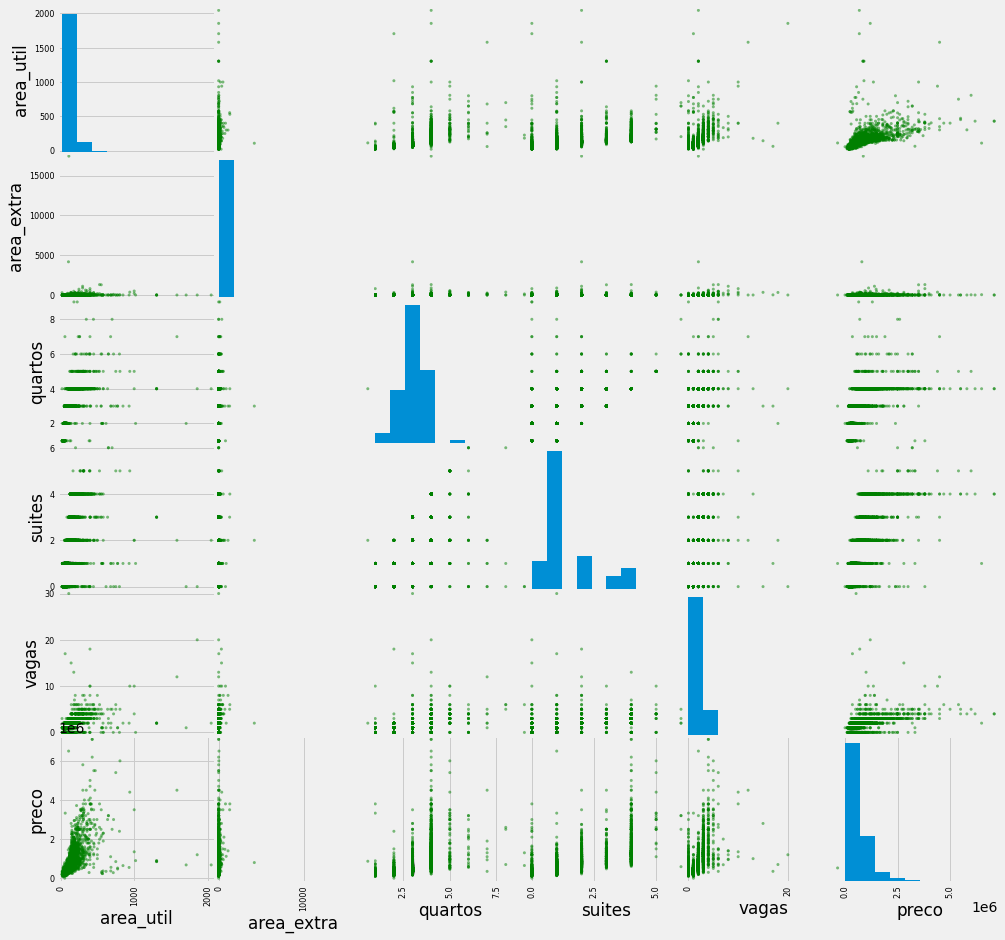

In [510]:
features = ['area_util', 'area_extra', 'quartos','suites','vagas', 'preco']
pd.plotting.scatter_matrix(train[features], color='green', figsize=(15,15), marker='.')
plt.show()

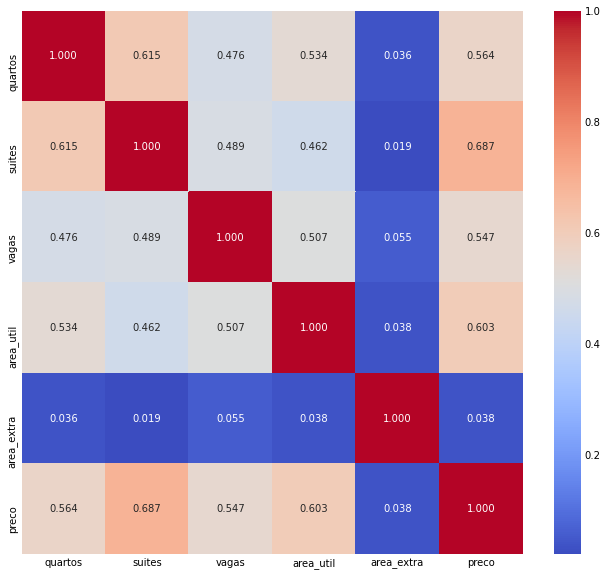

In [472]:
%matplotlib inline
fig = plt.figure(figsize=(10,10))
g = sns.heatmap(train[['quartos', 'suites', 'vagas', 'area_util', 'area_extra','preco']].corr(),
                annot=True, fmt='.3f', cmap='coolwarm')

In [45]:
profile = pandas_profiling.ProfileReport(train)

# MODELAGEM

In [1038]:
#importando a base de dados do arquivo CSV
train = pd.read_csv('conjunto_de_treinamento.csv')
#filtrando alguns valores extremos no preço
train = train.query('preco < 6000000')

test = pd.read_csv('conjunto_de_teste.csv')
#criando a coluna com os alvos
y = train['preco']

train.shape, y.shape

((4675, 21), (4675,))

## Engenharia de features + Preprocessamento

In [1039]:
#Preprocessamento de dados

#Aplicando one-hot-encoding na variável 'diferenciais', pois ela possui 83 valores distintos
#após a aplicação do one-hot-encoding selecionei as classes mais frequentes para usar no modelo
train = pd.get_dummies(train, columns=['tipo_vendedor','tipo', 'diferenciais','bairro'])
test = pd.get_dummies(test, columns=['tipo_vendedor','tipo', 'diferenciais', 'bairro'])

#engenharia de features
train['area_total'] = train['area_util'] + train['area_extra'] #area total do terreno
train['quantidade_comodos'] = train['suites'] + train['quartos'] #quantidade de comodos do imóvel
train['area_util_p_comodo'] = train['area_util']/(train['quartos'] + train['suites']) #estimativa de área por cômodo
train['area_util_sqrt'] = train['area_util'].map(lambda i: np.sqrt(i)) #raíz quadrada da área útil

test['area_total'] = test['area_util'] + test['area_extra']
test['quantidade_comodos'] = test['suites'] + test['quartos']
test['area_util_p_comodo'] = test['area_util']/(test['quartos'] + test['suites'])
test['area_util_sqrt'] = test['area_util'].map(lambda i: np.sqrt(i))


In [1040]:
#'diferenciais' e 'bairro' apresentam uma cardinalidade muito alta
#['diferenciais_sauna e campo de futebol', 'diferenciais_sauna e salao de festas', 'diferenciais_sauna e sala de ginastica']


features = train[['quartos', 'suites', 'vagas',  'area_extra', 'churrasqueira','estacionamento', 'piscina', 'playground', 'quadra', 's_festas','s_jogos',
                  's_ginastica', 'sauna', 'vista_mar', 'tipo_vendedor_Imobiliaria', 'tipo_vendedor_Pessoa Fisica', 'tipo_Apartamento', 'tipo_Casa', 'tipo_Loft',
                 'diferenciais_piscina e churrasqueira', 'diferenciais_nenhum', 'diferenciais_piscina e sauna', 'diferenciais_piscina e playground',
                  'diferenciais_salao de festas', 'area_total', 'quantidade_comodos', 'area_util_p_comodo', 'area_util_sqrt', 'bairro_Boa Viagem',
                  'bairro_Madalena', 'bairro_Torre', 'bairro_Casa Amarela', 'bairro_Espinheiro', 'bairro_Rosarinho']]


y_sqrt = np.sqrt(y)
y_log = np.log1p(y)

- o raíz da área util melhorou nossa validção, mas como tem uma grande correlação com a coluna AREA_UTIL resolvi tirá-la para melhorar o resultado.
- 

In [662]:
mdl_knn = make_pipeline(StandardScaler(), KNeighborsRegressor())
mdl_lr = make_pipeline(StandardScaler(), LinearRegression())
mdl_dtr = DecisionTreeRegressor()
mdl_rfr = RandomForestRegressor(random_state=29)
mdl_gbmr = GradientBoostingRegressor(random_state=29)
mdl_lgbmr = LGBMRegressor(random_state=29)
mdl_adar = AdaBoostRegressor(random_state=29)
mdl_svr = SVR()
mdl_xgb = xgb.XGBRegressor()

In [663]:
def valida_modelo(nome_modelo, modelo, x, y):
    kf = RepeatedKFold(n_splits=6, n_repeats=5, random_state=29)
    scores = cross_val_score(modelo, x, y, scoring='neg_root_mean_squared_error', cv=kf ).mean()
    print(nome_modelo)
    print('Erro: {:.2f}'.format(-scores))
    print()

In [664]:
valida_modelo('KNN', mdl_knn, features, y)
valida_modelo('Linear Regression', mdl_lr, features, y)
valida_modelo('Decision Tree', mdl_dtr, features, y)
valida_modelo('Random Forest', mdl_rfr, features, y)
valida_modelo('GBM', mdl_gbmr, features, y)
valida_modelo('Light GBM', mdl_lgbmr, features, y)
valida_modelo('Ada Boost', mdl_adar, features, y)
valida_modelo('SVR', mdl_svr, features, y)
valida_modelo('XGB', mdl_xgb, features, y)

KNN
Erro: 345460.43

Linear Regression
Erro: 381535.22

Decision Tree
Erro: 393564.51

Random Forest
Erro: 289241.05

GBM
Erro: 298680.51

Light GBM
Erro: 288744.16

Ada Boost
Erro: 467589.35

SVR
Erro: 640386.74

XGB
Erro: 303664.78



In [903]:
y.shape, features.shape

((4675,), (4680, 28))

In [1020]:
train['bairro'].value_counts()[:6]

Boa Viagem      1597
Madalena         327
Torre            239
Casa Amarela     225
Espinheiro       208
Rosarinho        202
Name: bairro, dtype: int64

In [1041]:

#scaler = MinMaxScaler()
#scaler.fit_transform(features['quartos', 'suites', 'vagas', 'area_extra', ])

kf = RepeatedKFold(n_splits=6, n_repeats=5, random_state=29)

#mdl_svr = SVR(C=300, gamma='scale', kernel='linear', epsilon=5)
#scores = -cross_val_score(mdl_svr, features, y, scoring='neg_root_mean_squared_error', cv=kf ).mean()
#print(scores)
mdl_lgbm = LGBMRegressor(n_estimators=55,learning_rate=0.09, random_state=29)
#mdl_lgbm = LGBMRegressor(n_estimators=55, learning_rate=0.09,num_leaves=27,max_depth=12, random_state=29)
scores = -cross_val_score(mdl_lgbm, features, y, scoring='neg_root_mean_squared_error', cv=kf ).mean()
print(scores)

#285569.8323219383 
#286040.75688800437 learning_rate=0.09
#279017.6208811623
#258509.63391663248
#258090.39712590675
#240800.71249458668

240800.71249458668


In [1042]:
#features usadas
features_test = test[['quartos', 'suites', 'vagas',  'area_extra', 'churrasqueira','estacionamento', 'piscina', 'playground', 'quadra', 's_festas','s_jogos',
                  's_ginastica', 'sauna', 'vista_mar', 'tipo_vendedor_Imobiliaria', 'tipo_vendedor_Pessoa Fisica', 'tipo_Apartamento', 'tipo_Casa', 'tipo_Loft',
                 'diferenciais_piscina e churrasqueira', 'diferenciais_nenhum', 'diferenciais_piscina e sauna', 'diferenciais_piscina e playground',
                  'diferenciais_salao de festas', 'area_total', 'quantidade_comodos', 'area_util_p_comodo', 'area_util_sqrt', 'bairro_Boa Viagem',
                  'bairro_Madalena', 'bairro_Torre', 'bairro_Casa Amarela', 'bairro_Espinheiro', 'bairro_Rosarinho']]
#usei como input a raíz dos preços
mdl_lgbm.fit(features, y_log)

#previsão dos dados de teste
p = mdl_lgbm.predict(features_test)
#p=p*p #transformar de raiz para original

p = np.e**p #transformar os resultados do log para o valor original

# Transformando em arquivo CSV pro Kaggle
sub = pd.Series(p, index=test['Id'], name='preco')

sub.to_csv("trabalho_2.csv", header=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 155 entries, Id to area_util_sqrt
dtypes: float64(2), int64(18), uint8(135)
memory usage: 576.3 KB


- Aplicando o Log ou a Raíz quadrada na coluna preço a distribuição se aproxima da normal, testei as duas hipóteses e a que apresentou o melhor resultado foi a do Log.

In [704]:
from scipy.stats import normaltest
normaltest(np.log1p(y))


NormaltestResult(statistic=410.74539179413114, pvalue=6.423495708519019e-90)

# Importances

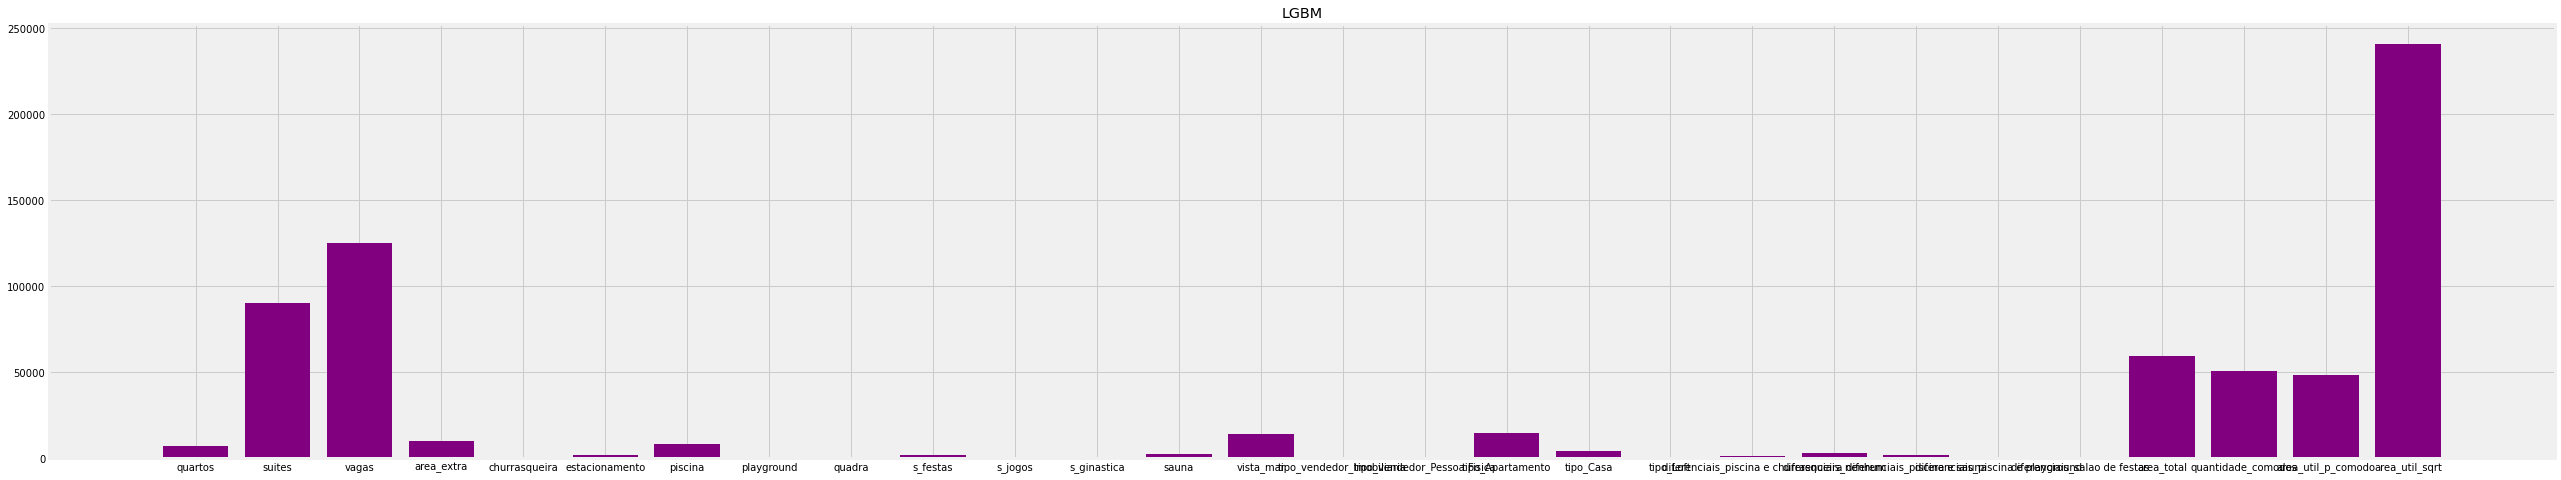

In [838]:
from sklearn.inspection import permutation_importance

mdl_lgbm = LGBMRegressor(random_state=29)
mdl_lgbm.fit(features, y)
importances_lgbm = permutation_importance(mdl_lgbm, features, y, scoring='neg_root_mean_squared_error', n_repeats=2, n_jobs=-1, random_state=29)

imp_lgbm = pd.Series(importances_lgbm['importances_mean'])

x = features.columns

fig=plt.figure(figsize=(40,8))
y= imp_lgbm
plt.bar(x, y, color='purple', label='lGBM')
plt.title('LGBM')
plt.show()

# Rede Neural - Tensorflow

In [ ]:
#Xtr, Xval, ytr, yval = train_test_split(features, y, train_size=0.7, random_state=29)
#Xtr.shape, Xval.shape, ytr.shape, yval.shape


scaler = MaxAbsScaler()
features = scaler.fit_transform(features)
features_test = scaler.transform(features_test)

y = y.values
#yval = yval.values

tf.random.set_seed(29)

#----------------------------------------------------------------------------------------------------------------
#camada inputs
inp = tfk.layers.Input((features.shape[1], ))

#primeira camada escondida
hid1 = tfk.layers.Dense(100, activation='relu')(inp)

#camada regularizadora
drop = tfk.layers.Dropout(0.4)(hid1)

#segunda camada escondida
hid2 = tfk.layers.Dense(100, activation='relu')(drop)

#camada de output
out = tfk.layers.Dense(1, activation='linear')(hid2)

mdl = tfk.Model(inp, out)
mdl.compile(loss='MeanAbsolutePercentageError' , optimizer='Adamax')
#categorical_crossentropy
mdl.summary()

es = tfk.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=15, mode='min', restore_best_weights=True)

mdl.fit(features, y, epochs=1500, shuffle=True, batch_size=1, callbacks=[es])

p = mdl.predict(features_test)
#----------------------------------------------------------------------------------------------------------------

# Testando dados externos (dados da cidade de recife)

In [392]:
train['bairro'].value_counts().count()

66

In [383]:
#dados retirados do site dados.recipe.pe.gov.br 
train2 = pd.read_csv('licenciamento_urbanistico.csv', sep=',').drop(['cnpj','data_conclusao','data_emissao_licenca','data_entrada',
                                                                     'data_validade_licenca','data_pagamento','inscricao_mercantil',
                                                                     'licenciamento_ambiental','licenciamento_sanitario','licenciamento_urbanistico',
                                                                     'razao_social', 'num_licenca','num_processo','porte_empreendimento',
                                                                     'potencial_empreendimento','processo_automatizado','situacao_processo',
                                                                     'tipo_mercantil','tipo_processo','uso_imovel','endereco_empreendimento',
                                                                    'razao_social_mercantil', 'dsqfl', 'assunto', ] ,axis=1)
#deixando o nome dos bairros só com a primeira letra meiúscula.
train2['bairro'] = train2['bairro'].map(lambda i: i.capitalize() )

#bairros encontrados no dataset original (train)
bairros_df_original = ['Boa Viagem', 'Madalena', 'Torre', 'Casa Amarela', 'Espinheiro',
       'Rosarinho', 'Casa Forte', 'Encruzilhada', 'Parnamirim', 'Gracas',
       'Tamarineira', 'Pina', 'Boa Vista', 'Aflitos', 'Cordeiro', 'Iputinga',
       'Jaqueira', 'Imbiribeira', 'Campo Grande', 'Apipucos', 'Poco da Panela',
       'Setubal', 'Varzea', 'Ilha do Retiro', 'Sto Amaro', 'Prado', 'Torreao',
       'Caxanga', 'Derby', 'Monteiro', 'Tejipio', 'Cid Universitaria',
       'Arruda', 'Piedade', 'San Martin', 'Engenho do Meio', 'Jd S Paulo',
       'Areias', 'Recife', 'Ilha do Leite', 'Bongi', 'Ipsep', 'Beira Rio',
       'Paissandu', 'Macaxeira', 'Barro', 'S Jose', 'Santana', 'Soledade',
       'Hipodromo', 'Poco', 'Benfica', 'Afogados', 'Cajueiro', 'Dois Irmaos',
       'Lagoa do Araca', 'Guabiraba', 'Estancia', 'Sancho', 'Agua Fria',
       'Cohab', 'Zumbi', 'Centro', 'Coelhos', 'Sto Antonio',
       'Ponto de Parada']

bairros_necessarios = train2.query('bairro in @bairros_df_original')

#separando a quantidade de empreencimentos de impacto por bairro
#empre_impacto_bairro = pd.crosstab(train2['bairro'], train2['empreendimento_de_impacto'])

#a = pd.Series(empre_impacto_bairro['Sim'].index)
#b = pd.Series(empre_impacto_bairro['Sim'])
#empre_impacto_bairro = pd.concat(a,b)

In [376]:
train2.head(10).T

,0,1,2,3,4,5,6,7,8,9
﻿areatotalconstruida,100,NaN,NaN,50,100,15,NaN,"362,70","363,53","3.130,32"
bairro,Areias,Brasilia teimosa,Brasilia teimosa,Areias,Areias,Areias,Brasilia teimosa,Iputinga,Iputinga,Ibura
categoria_empreendimento,Obra,Obra,Obra,Obra,Obra,Obra,Obra,Obra,Obra,Obra
empreendimento_de_impacto,Não,NaN,NaN,Não,Não,Não,NaN,Não,Não,Não
tipo_proc_licenciamento,Urbanístico,Urbanístico,Urbanístico,Urbanístico,Urbanístico,Urbanístico,Urbanístico,Urbanístico,Urbanístico,Urbanístico
valor_taxa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
valor_pago,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,-8.08907,-8.08907,-8.08907,-8.08907,-8.08907,-8.08907,-8.08907,NaN,NaN,-8.11051
longitude,-34.934,-34.934,-34.934,-34.934,-34.934,-34.934,-34.934,NaN,NaN,-34.9326


In [384]:
bairros_necessarios['empreendimento_de_impacto'].value_counts()

Não    6856
Sim     135
Name: empreendimento_de_impacto, dtype: int64

In [393]:
bairros_necessarios['bairro'].value_counts().count()

42

In [386]:
bairros_necessarios.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20236 entries, 0 to 36969
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ﻿areatotalconstruida       4518 non-null   object 
 1   bairro                     20236 non-null  object 
 2   categoria_empreendimento   20236 non-null  object 
 3   empreendimento_de_impacto  6991 non-null   object 
 4   tipo_proc_licenciamento    20236 non-null  object 
 5   valor_taxa                 9655 non-null   object 
 6   valor_pago                 9655 non-null   object 
 7   latitude                   18434 non-null  float64
 8   longitude                  18434 non-null  float64
dtypes: float64(2), object(7)
memory usage: 1.5+ MB


In [387]:
tabela = pd.crosstab(bairros_necessarios['bairro'], train2['empreendimento_de_impacto'])
tabela.head()

empreendimento_de_impacto,Não,Sim
bairro,,
Aflitos,65,5
Afogados,292,1
Apipucos,55,24
Areias,121,0
Arruda,95,2


In [389]:
tabela['Sim'].count()

42

In [ ]:
def procura_bairro(bairro):    
    for i in train['bairro'].value_counts().index:
        if i ==bairro:
            print('Tem', i)
            break
    print('busca finalizada')


In [990]:
train2 = train.iloc[:, 106:172]
train2

,bairro_Aflitos,bairro_Afogados,bairro_Agua Fria,bairro_Apipucos,bairro_Areias,bairro_Arruda,bairro_Barro,bairro_Beira Rio,bairro_Benfica,bairro_Boa Viagem,...,bairro_Setubal,bairro_Soledade,bairro_Sto Amaro,bairro_Sto Antonio,bairro_Tamarineira,bairro_Tejipio,bairro_Torre,bairro_Torreao,bairro_Varzea,bairro_Zumbi
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4678,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4679,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4680,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4681,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [998]:
train['preco'].shape, train2['bairro_Aflitos'].shape

((4661,), (4661,))

In [1014]:
b

0       0
1       0
2       0
3       0
4       0
       ..
4678    0
4679    0
4680    0
4681    0
4682    0
Name: bairro_Aflitos, Length: 4661, dtype: uint8

In [1006]:
from scipy.stats import ttest_ind
zeros=[]
uns=[]
alvo = train['preco']

for i in train2.columns:
    b = train2[i]
    
    for ind, j in enumerate(b):
        if j == 0:
            pr0 = alvo[ind]
            zeros.append(pr0)
        elif j == 1:
            pr1 = alvo[ind]
            uns.append(pr1)
    
    s, p_valor = ttest_ind(zeros,uns)
    print(i)
    print('p_valor: ',p_valor)

KeyError: 350